<a href="https://colab.research.google.com/github/chajmz/Dataquest/blob/master/Orbit_PEDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from pandas.io.json import json_normalize    
from datetime import datetime
from datetime import date
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
with open("/gdrive/My Drive/orbit_big.csv",encoding='utf-16') as data_file:    
    df = pd.read_csv(data_file)  

In [0]:
with open("/gdrive/My Drive/unit.csv") as data_file:    
    df_art_unit = pd.read_csv(data_file) 

In [0]:
pattern_examiner = r'[|]{2}([Pp][rimary]\w*\s\w*)[\:]([\s\w-]*)[|]+'
pattern_art_unit = r'[|]+([Aa]\w*\s[Uu]\w*[.: ]*\w{3}[=]+)([0-9]+)[|]+'
pattern_extension = r'\s([Ee]+\w{3}[=]+)([0-9]+)[|]+'
pattern_clms = r'\s([NnCcLl]{3}[=]+)([0-9]+)[|]+'
pattern_draw = r'\s([NnDdRr]{3}[=]+)([0-9]+)[|]+'
pattern_title = r'[(](\w{2}[D]?[0-9]+)[)][|]([\w, ().:=?-]+)'

assignees_list = ['THALES','BOEING','AIRBUS','HONEYWELL','SAFRAN','COLLINS','BAE SYSTEMS','GARMIN','PANASONIC','ROSEMOUNT','ELBIT','GE AVIATION'] 

In [0]:
def applyPattern(df_csv):
  df_csv['art_unit'] = df_csv['NO'].str.extract(pattern_art_unit)[1]
  df_csv['extension_days'] = df_csv['NO'].str.extract(pattern_extension)[1]
  df_csv['examiner'] = df_csv['NO'].str.extract(pattern_examiner)[1]
  df_csv['draw_nb'] = df_csv['NO'].str.extract(pattern_draw)[1]
  df_csv['clms_nb'] = df_csv['NO'].str.extract(pattern_clms)[1]
  df_csv['clean_title'] = df_csv['TI'].str.extract(pattern_title)[1]
  df_csv['clean_num'] = df_csv['TI'].str.extract(pattern_title)[0]
  return df_csv

In [0]:
#df_csv['examiner'].unique()
#r = ['(' + e[1:] + ')' + ' ou ' for e in exam['examiner']]
#lisT_exam_orbit = "".join(r)

In [8]:
df.sample(5,random_state=0)

,PR.§1,AP.§1,PN.PN,FAN,FAMILY_PN,EPRD,EAPD,EPD,EPDG,ACT.EED,TI,AB,PA,IN,RP,ADB,ICLM,OBJ,KEYW,KWIC,PCL,ACT.STATUS,ACT,DS,EPRC,NO,FD
10792,2009US-12509471|2012US-13467160,"US12/509,471|US13/467,160|WOUS2010/040088",US8753458|US8695669|US20120216957|WO2011/01692...,44305429,WO2011/016922 A1 2011-02-10 [WO201116922...,2009-07-26,2009-07-26,2011-01-27,2014-04-15,(WO201116922A1)|2013-01-26|(US8695669B2)|2029-...,(WO201116922)|Mapping tow splices in composite...,(WO2011/016922)|The three dimensional (3-D) lo...,BOEING,ENGELBART ROGER W|HANNEBAUM REED|RECTOR ERIC,"(WO201116922)|PLANK, Dennis R. et al. ([US])|(...","(WO2011/016922)|Accordingly, there is a need f...",(WO2011/016922)|1. A method of mapping the loc...,(WO2011/016922)|For the purposes of this descr...,"(US8753458)|TOW(100,48)|SPLICE LOCATION(100,30...",ECLM|(US8695669)|19. An apparatus configured t...,PCLO=156351000|PCLO=156064000|PCLX=156361000|P...,(WO201116922A1)|LAPSED|(US8695669B2)|GRANTED|(...,(WO201116922)|LEGAL DETAILS FOR WO2011/016922|...,(WO201116922)|National States: AE AG AL AM AO...,US,(WO201116922)|Extended kind: xc||(US2012021695...,"(US8695669)|Division of: US12/509,471 FDD=2009..."
13612,2014EP-0194526,"RU2015136394|US14/818,360|CN201510573992|JP201...",RU2695090|RU2015136394|US10001024|RU2015136394...,73094354,US10001024 B2 2018-06-19 [US10001024]...,2014-11-24,2014-11-24,2016-05-24,2018-06-19,(US10001024B2)|2036-05-26|(EP3023511A1)|2034-1...,(US10001024)|Abradable composition and seal of...,(US10001024)|The invention relates to a compos...,SAFRAN AERO BOOSTERS,SCHUSTER LAURENT,(US10001024)|Sandberg Phoenix & von Gontard P....,(US10001024)|The rotation of the rotor about i...,(US10001024)|1. A turbomachine comprising: a r...,(US10001024)|The invention relates to a compos...,"(US20160146034)|ROUNDED SUPPORT(100,25)|TURBOM...",EPD|2016-05-24||FAMILY_PN|(US10001024)|US10001...,PCLO=415173400|PCLX=106286500|PCLX=427447000|P...,(US10001024B2)|GRANTED|(EP3023511A1)|PENDING|(...,(US10001024)|LEGAL DETAILS FOR US20160146034|A...,(EP3023511)|Contracting States: AL AT BE BG C...,EP,(US20160146034)|Number of Drawings: NDR=2||Num...,(US10001024)|Previous publication: US201601460...
397,2017US-15724033,"EP18198516|US15/724,033",EP3468091|US20190103952,84025465,US20190103952 A1 2019-04-04 [US201901039...,2017-10-03,2017-10-03,2019-04-04,NaN,(US20190103952A1)|2037-10-03|(EP3468091A1)|201...,(US20190103952)|System and method for adaptive...,(US20190103952)|A method for aggregating usage...,HONEYWELL INTERNATIONAL|SATCOM1 FRANCE,GOUDAL FRANCOIS|KAUFFMANN ALBIN|NADER ADRIEN,"(EP3468091)|Houghton, Mark Phillip ; Patent Ou...","(US20190103952)|Accordingly, it is desirable t...",(US20190103952)|1 . A method for aggregating u...,(US20190103952)|The present invention generall...,"(EP3468091)|AIRCRAFT FLIGHT(100,23)|BROADBAND ...",AB|(US20190103952)|A method for aggregating us...,NaN,(US20190103952A1)|PENDING|(EP3468091A1)|LAPSED,(US20190103952)|LEGAL DETAILS FOR US2019010395...,(EP3468091)|Contracting States: AL AT BE BG C...,US,(US20190103952)|Number of Drawings: NDR=7||Num...,NaN
2095,2011FR-0056900,"EP12177427|CN201210262620|FR1156900|US13/552,104",EP2551191|CN102897328|FR2978423|US8818573|FR29...,8141440,US8818573 B2 2014-08-26 [US8818573]|...,2011-07-28,2011-07-28,2013-01-30,2014-08-26,(US8818573B2)|2033-02-20|(FR2978423B1)|2031-07...,(US8818573)|Method and device for detecting an...,(US8818573)|A detection device determines whet...,AIRBUS OPERATIONS|CNRS - CENTRE NATIONAL DE LA...,GOUPIL PHILIPPE|DAYRE RÉMY|LE BERRE HERVÉ|GHEO...,"(US8818573)|Wood, Herron & Evans, LLP|(FR29784...",(US8818573)|It is thus necessary to be in a po...,(US8818573)|1. A detection method for an uncon...,(US8818573)|The present invention thus relates...,"(EP2551191)|FEEDBACK COMMAND(100,7)|AIRCRAFT C...",AB|(US8818573)|A detection device determines w...,PCLO=701003000|PCLX=701039000,(US8818573B2)|GRANTED|(FR2978423B1)|GRANTED|(E...,(US8818573)|LEGAL DETAILS FOR US20130026287|Ac...,(EP2551191)|Con

In [9]:
print(df['EPD'][1])
#Date format %Y-%m-%d

date_col = ['EPRD', 'EAPD', 'EPD','EPDG']
for c in date_col:
  df[c] = pd.to_datetime(df[c])
df['days_grant'] = df['EPDG'] - df['EPRD']

2017-04-25


In [0]:
df = applyPattern(df)
#df_light = applyPattern(df).drop('FD',1)
#df_light.to_csv(r'/gdrive/My Drive/orbit_light.csv')

In [0]:
def getArtUnit(df_csv):
    #Let's extract first 2 num of group art unit
  df_csv['prefix_art'] = df_csv['art_unit'].str[:2]
  df_csv['suffix_art'] = df_csv['art_unit'].str[2:]
  return df_csv

In [12]:
df = getArtUnit(df)
df.shape

(15018, 37)

In [0]:
def getTopPrefixForAssignee(assignee,n,df):
  df_a = df[df['PA'].str.contains(assignee)]
  top_prefix = df_a['prefix_art'].value_counts()
  return (top_prefix[top_prefix>n],assignee)

def normalizeAssignee(df):
  list_df = []
  df['norm_assignee'] = 'OTHER'
  for a in assignees_list:
    sub_df = df[df['PA'].str.contains(a)]
    sub_df['norm_assignee'] = a
    list_df.append(sub_df)
  list_df.append(df[df['PA'] == 'OTHER'])
  return pd.concat(list_df,axis=0)


In [14]:
df = normalizeAssignee(df)
df['granted_bool'] = df['days_grant'].notnull()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [15]:
df['granted_bool'].value_counts(dropna=False)

True     11922
False     3019
Name: granted_bool, dtype: int64

Text(12.334999999999994, 0.5, 'Assignees')

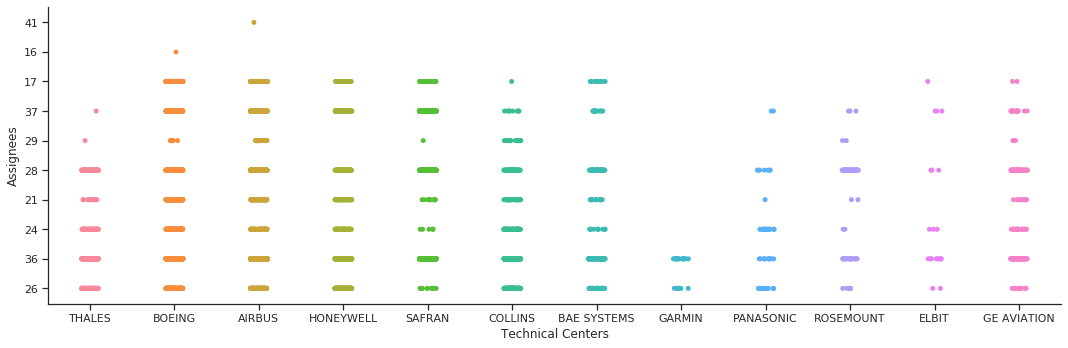

In [16]:
list_top_prefix = [getTopPrefixForAssignee(assignee,0,df) for assignee in assignees_list]
#sns.distplot( y=list_top_prefix[0][0], x=df_l_exam['prefix_art'] )
sns.set(style="ticks", color_codes=True)
fig_sns = sns.catplot(x="norm_assignee", y="prefix_art", data=df[df['prefix_art'].notnull()],height = 5,aspect=3)
plt.xlabel('Technical Centers')
plt.ylabel('Assignees')

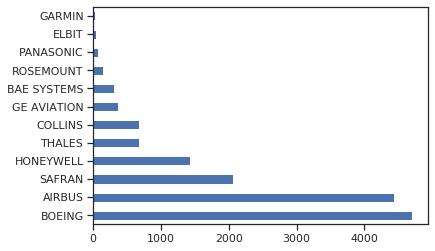

In [17]:
df['norm_assignee'].value_counts(dropna=True).head(30).plot(kind='barh')

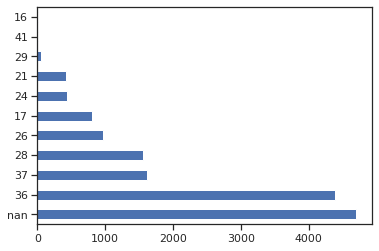

In [18]:
df['prefix_art'].value_counts(dropna=False).plot(kind='barh')

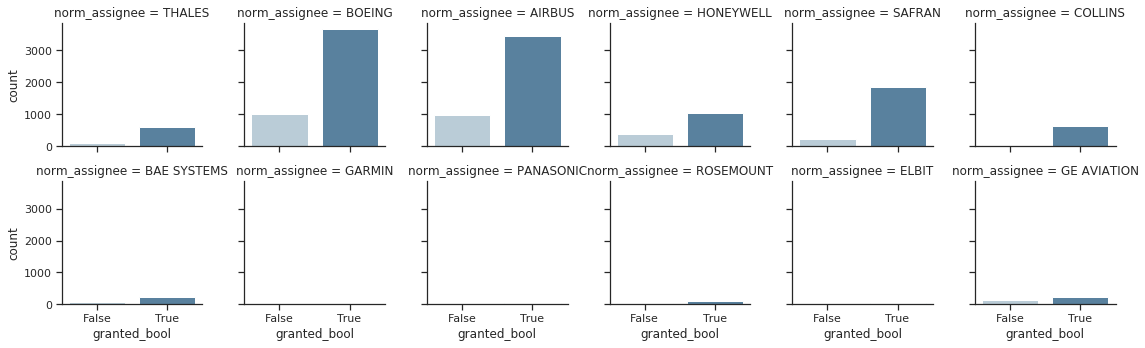

In [19]:
from  matplotlib.ticker import PercentFormatter
g = sns.catplot("granted_bool", col="norm_assignee", col_wrap=6,data=df, kind="count", height=2.5, aspect=1.05,palette="Blues",saturation=.5) 

plt.show()

(453,)

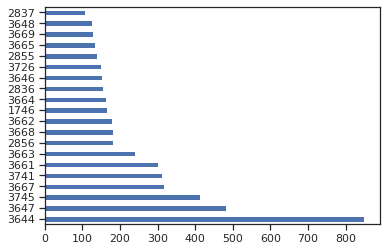

In [20]:
df['art_unit'].value_counts().head(20).plot(kind='barh')
df['art_unit'].value_counts().shape

242

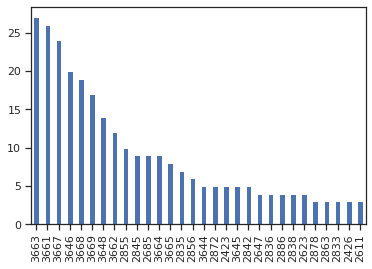

In [21]:
df_thales = df[df['norm_assignee'] == 'THALES']
df_t = df_thales['art_unit'].value_counts().head(30).plot(kind='bar')
df_t_sum = df_thales['art_unit'].value_counts().head(20).sum()
df_t_sum

In [22]:
df_thales['art_unit'].value_counts().describe()

count    140.000000
mean       3.071429
std        4.679118
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       27.000000
Name: art_unit, dtype: float64

count    169.000000
mean       3.804734
std        6.465364
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       50.000000
Name: art_unit, dtype: float64

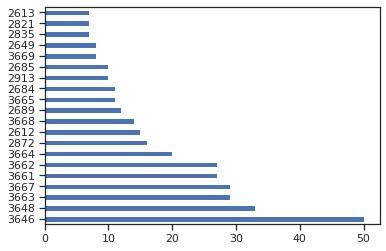

In [23]:
df_c = df[df['norm_assignee'] == 'COLLINS']
df_collins = df_c['art_unit'].value_counts().head(20).plot(kind='barh')
df_c['art_unit'].value_counts().describe()

In [0]:
#Les art units avec les meilleurs stats
#Les examinateurs avec les meilleurs stats dans un même art unit
#moyenne générale dans un art unit 
#calcul du temps depuis la première prio 
#temps moyen pour délivrer brevet par acteur
#examinateur meme si pas delivré ?
#stat par examinateur

In [0]:
from datetime import date
def getAssigneeDataFrame(assignee,df):
  return df[df['norm_assignee'] == assignee]

def computeTimeSinceFiling(df):
  df['days_filing'] = datetime.today() - df['EPRD']
  return df

def avgTimeToGrant(df):
  dic = {}
  for a in assignees_list:
    df_a = getAssigneeDataFrame(a,df)
    df_a = df_a[df_a['EPDG'].notnull()]
    dic[a] = df_a['days_grant'].mean().days
  return dic

In [0]:
df_boeing = getAssigneeDataFrame('BOEING',df)

In [27]:
df_boeing['days_filing'] = datetime.now() - df_boeing['EPRD']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df = computeTimeSinceFiling(df)
dic_avg = avgTimeToGrant(df)
dic_avg['AIRBUS']

1174

In [0]:
df_dic = pd.DataFrame([dic_avg]).T
df_dic = df_dic.rename(columns={df_dic.columns[0]:'avg_day'})

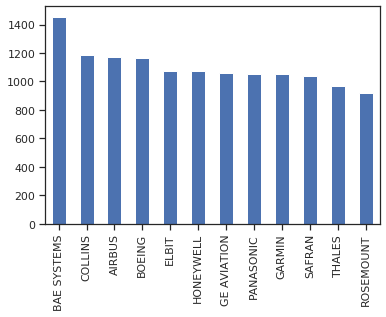

In [30]:
df_dic['avg_day'].sort_values(ascending=False).plot(kind='bar')

In [0]:
def getYearFilingForAssignee(assignee,df):
  df = getAssigneeDataFrame(assignee,df)
  g = df['EPRD'].dt.year.value_counts().sort_index().plot(kind='bar')
  g.set_xlabel('Year of Filing')
  g.set_ylabel('Number of Patent Filed')
  g.set_title('Year of Filing for the dataset')
  return g
#g.set_xlim()

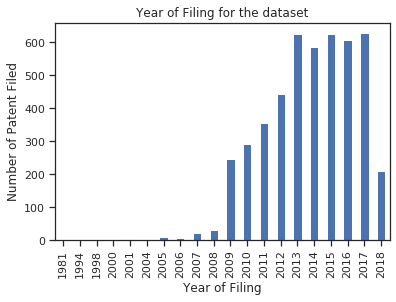

In [32]:
th = getYearFilingForAssignee('BOEING',df)

In [0]:
df['priority_year'] =  df['EPRD'].dt.year

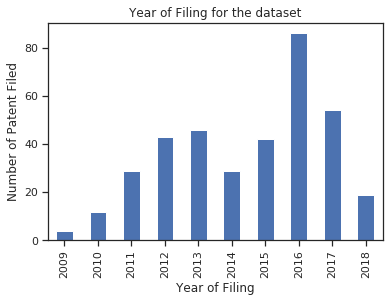

In [34]:
ge = getYearFilingForAssignee('GE AVIATION',df)

In [35]:
exam_thales = df_thales['examiner'].value_counts()
exam_thales_2 = exam_thales[exam_thales>2]
exam_thales_2

 Tarcza Thomas          14
 Cheung Calvin           7
 Cheung Mary             7
 Olszewski John R        6
 Nguyen Tan Q            6
 Black Thomas G          6
 Edwards Jerrah          5
 Camby Richard           4
 Patel Harshad R         4
 Bruckart Benjamin R     4
 Sotomayor John B        4
 Khatib Rami             4
 Ratcliffe Luke          4
 Trammell James          4
 Nguyen John Q           4
 Phan Dao                4
 Brainard Timothy A      3
 Tran Khoi               3
 Marc-Coleman Marthe     3
 Lin Abby Y              3
 Nguyen Tai T            3
 Barker Matthew M        3
 Badii Behrang           3
 Gregory Bernarr E       3
 Nguyen Sang             3
 Shafi Muhammad          3
 Gregory Bernarr         3
Name: examiner, dtype: int64

In [36]:
#peut on avoir un examiner si pas granted ? 
df_b_exam = df_boeing[df_boeing['granted_bool'] == False]

print(df_b_exam[df_b_exam['FD'].notnull()]['FD'])


329      (US20180362149)|Provisional Appl: US62/519,693...
543      (US20190241247)|Provisional Appl: US62/628,254...
761      (US20190144112)|CIP of: US15/815,689 FDD=2017-...
1426     (US20190048959)|Continuation of: US15/867,940 ...
1796     (US20190080615)|CIP of: US15/703,053 FDD=2017-...
                               ...                        
14507    (US20190270296)|Provisional Appl: US62/638,055...
14509    (US20190241752)|Provisional Appl: US62/625,785...
14510    (US20190240635)|Provisional Appl: US62/625,792...
14516    (US20190002739)|Provisional Appl: US62/527,432...
14828    (US20180255455)|CIP of: US15/451,291 FDD=2017-...
Name: FD, Length: 72, dtype: object


In [37]:
print(df_b_exam['FD'][1796])

(US20190080615)|CIP of: US15/703,053 FDD=2017-09-13 [2017US-15703053]


In [38]:
all_ex = df[df['examiner'].notnull()]['examiner'].unique()
all_l = []
all_ex[0]
df_e = df[df['examiner'] == all_ex[0]]
df_e

,PR.§1,AP.§1,PN.PN,FAN,FAMILY_PN,EPRD,EAPD,EPD,EPDG,ACT.EED,TI,AB,PA,IN,RP,ADB,ICLM,OBJ,KEYW,KWIC,PCL,ACT.STATUS,ACT,DS,EPRC,NO,FD,days_grant,art_unit,extension_days,examiner,draw_nb,clms_nb,clean_title,clean_num,prefix_art,suffix_art,norm_assignee,granted_bool,days_filing,priority_year
10,2016FR-0001112,"US15/652,801|FR1601112|CN201710585460",US10453234|FR3054314|US20180075632|CN107628258...,78601936,US10453234 B2 2019-10-22 [US10453234]...,2016-07-19,2016-07-19,2018-01-26,2018-08-31,(US10453234B2)|2037-07-18|(FR3054314B1)|2036-0...,(US10453234)|System for displaying avionic dat...,(US10453234)|The present invention relates to ...,THALES,Baron Luc|Garnavault Christophe|Aymeric Bruno|...,(US10453234)|Pearne & Gordon LLP|(FR3054314)|C...,(US10453234)|Other devices typically make it p...,(US10453234)|1. A system for displaying avioni...,(US10453234)|The present invention relates to ...,"(US10453234)|DISPLAY FORMAT(100,96)|AIRCRAFT(1...",AB|(US10453234)|The present invention relates ...,NaN,(US10453234B2)|GRANTED|(FR3054314B1)|GRANTED|(...,(US10453234)|LEGAL DETAILS FOR US20180075632|A...,NaN,FR,(US20180075632)|Number of Drawings: NDR=4||Num...,(US10453234)|Previous publication: US201800756...,773 days,2611,NaN,Wu Yanna,4,10,System for displaying avionic data on at least...,US10453234,26,11,THALES,True,1202 days 17:40:23.945571,2016
11794,2016US-15185785,"US15/185,785",US10417803|US20170365086,78089253,US10417803 B2 2019-09-17 [US10417803]...,2016-06-17,2016-06-17,2017-12-21,2019-09-17,2036-06-17,(US10417803)|Multiple-pass rendering of a digi...,(US10417803)|A method is provided for renderin...,BOEING,FLOYD JOSEPH FRANK|EAMES PATRICK JAMES|HADLEY ...,(US10417803)|Womble Bond Dickinson (US) LLP,(US10417803)|Display of an aircraft and its pa...,(US10417803)|1. An apparatus for rendering a s...,(US10417803)|The present disclosure relates ge...,"(US10417803)|PASS RENDERING(100,49)|SCENE(100,...",ADB|(US10417803)|Display of an aircraft and it...,NaN,GRANTED,(US10417803)|LEGAL DETAILS FOR US20170365086|A...,NaN,US,(US20170365086)|Number of Drawings: NDR=6||Num...,(US10417803)|Previous publication: US201703650...,1187 days,2611,NaN,Wu Yanna,6,24,Multiple-pass rendering of a digital three-dim...,US10417803,26,11,BOEING,True,1234 days 17:40:23.945571,2016


In [39]:
def is_cjk(character):
    """"
    Checks whether character is CJK.

        >>> is_cjk(u'\u33fe')
        True
        >>> is_cjk(u'\uFE5F')
        False

    :param character: The character that needs to be checked.
    :type character: char
    :return: bool
    """
    return any([start <= ord(character) <= end for start, end in 
                [(4352, 4607), (11904, 42191), (43072, 43135), (44032, 55215), 
                 (63744, 64255), (65072, 65103), (65381, 65500), 
                 (131072, 196607)]
                ])
    
def isExaminerCJK(s):
  for c in s:
    if is_cjk(c):
      return True
  return False

isExaminerCJK('AAPOKMAKAMMA KALKJKLJLKA--')

False

In [0]:
#First value is examiner
#Second is mean days for grant patent
#Third is max value for granting a patent
#Fourth is the min days required for granting a patent
#Fifth is the number of case processed by the examiner
#Sixth is finally the group_art unit in which the examiner contribute the most
#Seventh is the company the most processed by the examiner (might be Boeing, Airbus or Safran due to the number ...)
all_l = []
for ex in all_ex:
  if isExaminerCJK(ex) == False :
    df_e = df[df['examiner'] == ex]
    meanV = df_e['days_grant'].mean().days
    maxV = df_e['days_grant'].max().days
    minV = df_e['days_grant'].min().days
    num_case = df_e.shape[0]
    art = df_e['art_unit'].value_counts().keys().tolist()[0]
    top_assignee = df_e['norm_assignee'].value_counts().keys().tolist()[0]
    percent_assignee = round((df_e['norm_assignee'].value_counts().head(1)[0])/num_case,1)
    l = [ex,meanV,maxV,minV,num_case,int(art),top_assignee,percent_assignee]
    all_l.append(l)

In [0]:
df_exam_s = pd.DataFrame(all_l, columns=['examiner','avg_for_grant','max_for_grant','min_for_grant','num_case','top_art_unit','top_assignee_processed','assignee_percent'])

In [42]:
df_exam_s.sample(10)

,examiner,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent
2485,Zhao Don G,858,858,858,1,2493,PANASONIC,1.0
364,Kiswanto Nicholas,989,1330,753,7,3667,AIRBUS,0.6
1356,Mellott James,1373,1373,1373,1,1712,BOEING,1.0
561,Yun Jurie,905,987,823,2,2882,BOEING,1.0
2211,Chen Alan,1528,1528,1528,1,2129,SAFRAN,1.0
1238,Patel Devang R,1152,1706,932,6,1735,AIRBUS,0.7
80,Camby Richard,1000,1736,623,17,3661,THALES,0.2
2185,Ponomarenko Nicholas,818,982,655,2,2833,SAFRAN,0.5
214,Jagan Mirellys,928,1082,777,4,2855,THALES,0.2
122,Ngo Ricky,1343,1343,1343,1,2464,THALES,1.0


In [43]:
df_exam_s['num_case'] = df_exam_s['num_case'].astype(int)
df_exam_s['prefix_art'] = round(df_exam_s['top_art_unit']/100,0)
df_exam_s.sample(4)

,examiner,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent,prefix_art
2477,Bernatz Kevin,1814,1814,1814,1,1785,BAE SYSTEMS,1.0,18.0
1848,Bruce David V,1196,1196,1196,1,2875,AIRBUS,1.0,29.0
798,McNally Daniel,1267,1841,799,7,1746,BOEING,0.9,17.0
1523,Wong Edna,2014,2014,2014,1,1759,BOEING,1.0,18.0


In [0]:
df_high_exam = df_exam_s[df_exam_s['num_case']>4]

In [45]:
df_high_exam

,examiner,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent,prefix_art
1,Cheung Mary,796,1691,272,64,3667,AIRBUS,0.3,37.0
2,Cheung Calvin,971,1652,518,44,3668,AIRBUS,0.3,37.0
3,Edwards Jerrah,986,2015,524,29,3667,AIRBUS,0.2,37.0
4,Trammell James,1047,2175,350,47,3667,AIRBUS,0.3,37.0
6,Butler Rodney,755,1076,468,15,3667,AIRBUS,0.4,37.0
...,...,...,...,...,...,...,...,...,...
2048,Nguyen Andrew H,1053,1729,756,6,3741,SAFRAN,0.7,37.0
2192,Joyce William C,881,1278,742,8,3658,SAFRAN,1.0,37.0
2210,Seabe Justin D,933,1594,552,10,3745,SAFRAN,1.0,37.0
2216,Edgar Richard A,1228,1764,552,7,3745,SAFRAN,1.0,37.0


In [46]:
df['art_unit'].value_counts().head(20)

3644    848
3647    483
3745    414
3667    317
3741    311
3661    302
3663    241
2856    182
3668    181
3662    178
1746    167
3664    164
2836    154
3646    152
3726    150
2855    138
3665    134
3669    129
3648    126
2837    108
Name: art_unit, dtype: int64

In [0]:
#17XX = Chemical and Materials Engineering fields.
#28XX = Semiconductors, Electrical and Optical Systems and Components
#24XX = Computer Networks, Multiplex, Cable and Cryptography/Security.
#21XX = Computer Architecture Software and Information Security.
#28XX = Semiconductors, Electrical and Optical Systems and Components.
#29XX = including Designs.
#36XX = Transportation, Electronic Commerce, Construction, Agriculture, Licensing and Review.
#37XX = Mechanical Engineering, Manufacturing and Products.


In [47]:
df_art_unit['prefix_art'] = round(df_art_unit['Art Unit']/100,0)
df_art_unit.sample(4)

,Art Unit,Class,Class Title,Subclass Ranges From,Subclass Ranges To,prefix_art
219,1644,514,"DRUG, BIO-AFFECTING AND BODY TREATING COMPOSIT...",9.3,NaN,16.0
740,1786,428,STOCK MATERIAL OR MISCELLANEOUS ARTICLES,357,401,18.0
760,1787,428,STOCK MATERIAL OR MISCELLANEOUS ARTICLES,543,NaN,18.0
346,1656,536,ORGANIC COMPOUNDS -- PART OF THE CLASS 532-570...,23.6,23.74,17.0


In [48]:
#Let's focus on direct competitors : GE, HWL & RC
df_competitors = df[(df.norm_assignee == 'ELBIT') | (df.norm_assignee == 'GARMIN') | (df.norm_assignee == 'THALES') | (df.norm_assignee == 'GE AVIATION') | (df.norm_assignee == 'COLLINS') | (df.norm_assignee == 'HONEYWELL')]
df_competitors.sample(10)

,PR.§1,AP.§1,PN.PN,FAN,FAMILY_PN,EPRD,EAPD,EPD,EPDG,ACT.EED,TI,AB,PA,IN,RP,ADB,ICLM,OBJ,KEYW,KWIC,PCL,ACT.STATUS,ACT,DS,EPRC,NO,FD,days_grant,art_unit,extension_days,examiner,draw_nb,clms_nb,clean_title,clean_num,prefix_art,suffix_art,norm_assignee,granted_bool,days_filing,priority_year
5913,2016US-15385069|2016US-62378960,"US15/385,069|EP17187154",US10443541|EP3287628|US20180209376|EP3287628,80623138,US10443541 B2 2019-10-15 [US10443541]...,2016-08-24,2016-12-20,2018-02-28,2019-03-20,(US10443541B2)|2038-01-19|(EP3287628B1)|2037-0...,(US10443541)|Aircraft thrust reverser system w...,(US10443541)|A thrust reverser system for a ga...,HONEYWELL INTERNATIONAL,CHAKKERA KEVIN K|BIRCHAK DANIEL C|CHRISTENSEN ...,"(US10443541)|Lorenz & Kopf, LLP|(EP3287628)|Ho...",(US10443541)|It will be appreciated that the d...,(US10443541)|1. A thrust reverser system for a...,(US10443541)|The present invention generally r...,"(US10443541)|THRUST REVERSER(100,34)|GAS TURBI...",EPD|2018-02-28||ETIH|(US20180209376)|Aircraft ...,NaN,(US10443541B2)|GRANTED|(EP3287628B1)|GRANTED,(US10443541)|LEGAL DETAILS FOR US20180209376|A...,(EP3287628)|Contracting States: AL AT BE BG C...,US,(US20180209376)|Number of Drawings: NDR=5||Num...,"(US10443541)|Provisional Appl: US62/378,960 FD...",938 days,3741,395,Nguyen Andrew H,5,17,Aircraft thrust reverser system with alternate...,US10443541,37,41,HONEYWELL,True,1166 days 17:40:23.945571,2016
12722,2015US-14945815,"US14/945,815",US20170147472,76194391,US20170147472 A1 2017-05-25 [US20170147472],2015-11-19,2015-11-19,2017-05-25,NaT,2035-11-19,(US20170147472)|Systems and methods for a real...,(US20170147472)|Systems and methods for a real...,HONEYWELL INTERNATIONAL|PERFORMANCE SOFTWARE,ECKERT RICHARD J|PETERS JON|TAM HO YIN|SOLORZA...,NaN,(US20170147472)|Because the conditions arise d...,(US20170147472)|1. A system for acquiring data...,(US20170147472)|Systems and methods for a real...,"(US20170147472)|STORED DATA(100,65)|REALTIME E...",ADB|(US20170147472)|Because the conditions ari...,NaN,PENDING,(US20170147472)|LEGAL DETAILS FOR US2017014747...,NaN,US,(US20170147472)|Number of Drawings: NDR=4||Num...,NaN,NaT,NaN,NaN,NaN,4,30,Systems and methods for a real time embedded t...,US20170147472,NaN,NaN,HONEYWELL,False,1445 days 17:40:23.945571,2015
14446,2015US-14949437,"EP16190016|US14/949,437",EP3171132|US9709405|US20170146347|EP3171132,76193971,US9709405 B2 2017-07-18 [US9709405]|...,2015-11-23,2015-11-23,2017-05-24,2017-07-18,(US9709405B2)|2035-11-23|(EP3171132B1)|2036-09-21,(US9709405)|Methods for attitude and heading r...,(US9709405)|An attitude and heading reference ...,HONEYWELL INTERNATIONAL,SOTAK MILOS|MALINAK PAVOL|KANA ZDENEK|DUNIK JI...,(US9709405)|Fogg & Powers LLC|(EP3171132)|Houg...,"(US9709405)|In a first technique, a first uppe...",(US9709405)|1. An attitude and heading referen...,(US9709405)|An attitude and heading reference ...,"(EP3171132)|AND HEADING REFERENCE SYSTEM(100,3...","ECLM|(US9709405)|7. The AHRS of claim 1, where...",NaN,(US9709405B2)|GRANTED|(EP3171132B1)|GRANTED,(US9709405)|LEGAL DETAILS FOR US20170146347|Ac...,(EP3171132)|Contracting States: AL AT BE BG C...,US,(US20170146347)|Number of Drawings: NDR=4||Num...,(US9709405)|Previous publication: US2017014634...,603 days,3663,NaN,Oritz Angela,4,19,Methods for attitude and heading reference sys...,US9709405,36,63,HONEYWELL,True,1441 days 17:40:23.945571,2015
14560,2017FR-0000985,"FR1700985|US16/119,643|EP18192384",FR3071684|US20190097676|EP3461012,83930299,US20190097676 A1 2019-03-28 [US201900976...,2017-09-26,2017-09-26,2019-03-27,NaT,(US20190097676A1)|2038-08-31|(FR3071684A1)|203...,(US20190097676)|Method for transmitting additi...,(US20190097676)|A method is provided for trans...,THALES,MARTIN PAULINE|CALMETTES THIBAUD,(FR3071684)|MARKS & CLERK FRANCE ([FR])|Reg. N...,(US20190097676)|Such a method makes it possibl...,(US20190097676)|1 . A method for transmitting ...,(US20190097676)|The invention pertains to a me...,"(FR3071684)|NAVIGATION(100

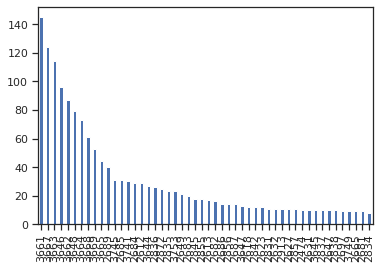

In [49]:
top_art_competitors = df_competitors['art_unit'].value_counts()
top_art_competitors.head(50).plot(kind='bar')

In [50]:
mean_comp_art = df_competitors['art_unit'].value_counts().mean()
list_top = top_art_competitors[top_art_competitors>mean_comp_art]
list_top

3661    145
3667    124
3663    114
3646     96
3662     87
3648     79
3664     73
3668     61
3669     53
3665     44
2689     40
3745     31
2685     31
3741     30
2684     29
2612     29
3644     27
2836     26
2872     25
2835     23
3753     23
2649     21
2683     20
2845     18
2855     18
2613     17
2682     16
2686     14
2856     14
2687     14
3647     13
2618     12
2842     12
2623     12
2831     11
2632     11
2913     11
2627     11
2857     11
2474     10
2631     10
3645     10
2837     10
2647     10
2838     10
2697      9
3749      9
2665      9
2681      9
2834      8
3653      8
2821      8
3657      8
2113      8
1776      8
3658      8
Name: art_unit, dtype: int64

In [51]:
s = ""
for c in list_top:
  s += str(c) + " or "
s

'145 or 124 or 114 or 96 or 87 or 79 or 73 or 61 or 53 or 44 or 40 or 31 or 31 or 30 or 29 or 29 or 27 or 26 or 25 or 23 or 23 or 21 or 20 or 18 or 18 or 17 or 16 or 14 or 14 or 14 or 13 or 12 or 12 or 12 or 11 or 11 or 11 or 11 or 11 or 10 or 10 or 10 or 10 or 10 or 10 or 9 or 9 or 9 or 9 or 8 or 8 or 8 or 8 or 8 or 8 or 8 or '

In [0]:
df_competitors_copy = df_competitors.copy()
df_exam_copy = df_exam_s.copy()

In [53]:
merged_exam = pd.merge(df_competitors_copy,df_exam_copy,on='examiner')
merged_exam.sample(4)

,PR.§1,AP.§1,PN.PN,FAN,FAMILY_PN,EPRD,EAPD,EPD,EPDG,ACT.EED,TI,AB,PA,IN,RP,ADB,ICLM,OBJ,KEYW,KWIC,PCL,ACT.STATUS,ACT,DS,EPRC,NO,FD,days_grant,art_unit,extension_days,examiner,draw_nb,clms_nb,clean_title,clean_num,prefix_art_x,suffix_art,norm_assignee,granted_bool,days_filing,priority_year,avg_for_grant,max_for_grant,min_for_grant,num_case,top_art_unit,top_assignee_processed,assignee_percent,prefix_art_y
1821,2009US-61290262|2010US-12695736|2010US-12959250,"CA2760872|US12/695,736|JP2011263814|RU20111491...",CA2760872|US9978251|JP6058885|RU2602700|EP2461...,4185287,US8442801 B2 2013-05-14 [US8442801]|...,2009-12-28,2010-01-28,2011-06-29,2013-05-14,(US8442801B2)|2031-08-04|(US9978251B2)|2033-10...,(US8442801)|Wireless location-based system for...,(US8442801)|A method and apparatus are provide...,HONEYWELL|HONEYWELL INTERNATIONAL,GONIA PATRICK S|KOLAVENNU SOUMITRI|CABUZ CLEOP...,(US8442801)|Husch Blackwell LLP|(US9978251)|Wi...,"(US8442801)|Based on the foregoing, a need exi...",(US8442801)|1. A method comprising: providing ...,(US8442801)|The field of the invention relates...,"(US20110161044)|TRANSCEIVER(100,101)|HAZARDOUS...",ECLM|(US8442801)|(...)as in claim 8 wherein th...,PCLO=702150000|PCLX=702023000|PCLX=702024000|P...,(US8442801B2)|GRANTED|(US9978251B2)|GRANTED|(E...,(US8442801)|LEGAL DETAILS FOR US20110161044|Ac...,(EP2339556)|Contracting States: AL AT BE BG C...,US,(US20110161044)|Number of Drawings: NDR=1||Num...,"(US8442801)|CIP of: US12/695,736 FDD=2010-01-2...",1233 days,2857,245,Henson Mischita,1,20,Wireless location-based system for detecting h...,US8442801,28,57,HONEYWELL,True,3597 days 17:40:23.945571,2009,1468,2227,771,5,2865,BOEING,0.6,29.0
1355,2014US-14200263,"US14/200,263|CN201510099355",US9580180|US20150251765|CN104890878,70811470,US9580180 B2 2017-02-28 [US9580180]|...,2014-03-07,2014-03-07,2015-09-09,2017-02-28,(US9580180B2)|2034-06-01|(CN104890878A)|2035-0...,(US9580180)|Low-pressure bleed air aircraft en...,(US9580180)|An aircraft environmental control ...,HONEYWELL INTERNATIONAL,JONQUERES MICHEL A|ARAKI ROY,(US9580180)|Shimokaji IP|(CN104890878)|WU CHAO...,(US9580180)|This invention intends instead to ...,(US9580180)|1. An aircraft environmental contr...,(US9580180)|In one aspect of the present inven...,"(US9580180)|AIRCRAFT(100,41)|ENVIRONMENTAL CON...",AB|(US9580180)|An aircraft environmental contr...,PCLO=062086000|PCLX=062401000,(US9580180B2)|GRANTED|(CN104890878A)|PENDING,(US9580180)|LEGAL DETAILS FOR US20150251765|Ac...,NaN,US,(US20150251765)|Number of Drawings: NDR=3||Num...,(US9580180)|Previous publication: US2015025176...,1089 days,3744,86,Duke Emmanuel,3,20,Low-pressure bleed air aircraft environmental ...,US9580180,37,44,HONEYWELL,True,2067 days 17:40:23.945571,2014,925,1089,761,2,3744,HONEYWELL,0.5,37.0
1381,2017US-15463569,"US15/463,569",US10086953|US20180265220,81304139,US10086953 B1 2018-10-02 [US10086953]...,2017-03-20,2017-03-20,2018-09-20,2018-10-02,2037-03-20,(US10086953)|Aircraft beacon light synchroniza...,"(US10086953)|A synchronized, aircraft light sy...",HONEYWELL INTERNATIONAL,LI QIXIANG,"(US10086953)|Lorenz & Kopf, LLP","(US20180265220)|Therefore, it is desirable to ...",(US20180265220)|1. An LED-based synchronized l...,"(US20180265220)|Additionally, provided is an L...","(US10086953)|LIGHT EMITTING DIODE(100,60)|PLC ...","AB|(US10086953)|A synchronized, aircraft light...",NaN,GRANTED,(US10086953)|LEGAL DETAILS FOR US20180265220|A...,NaN,US,(US20180265220)|Number of Drawings: NDR=6||Num...,NaN,561 days,2844,NaN,Le Tung X,6,20,Aircraft beacon light synchronization,US10086953,28,44,HONEYWELL,True,958 days 17:40:23.945571,2017,797,1034,561,2,2844,HONEYWELL,0.5,28.0
670,2012US-13605485|2014US-14530888,"US14/530,888|US13/605,485|WOUS2013/055932",US9529431|US20150049887|US8879760|WO2014/03925...,61882040,WO2014/039258 A1 2014-03-13 [WO201439258...,2012-09-06,2012-09-06,2014-03-06,2014-11-04,(WO201439258A1)|2016-03-06|(US8879760B2)|2032-...,(WO201439258)|Directional sound systems and

In [0]:
def getListExaminer(df,n):
  top_df = df[df['num_case'] > n]
  return top_df['examiner'].unique()

In [55]:
exam_over_3 = getListExaminer(merged_exam,3)
ss = ""
for e in exam_over_3:
  ss += '('+e+')'+" ou "
ss

'( Cheung Mary) ou ( Cheung Calvin) ou ( Edwards Jerrah) ou ( Trammell James) ou ( Butler Rodney) ou ( Lin Abby Y) ou ( Sample Jonathan L) ou ( Nguyen Tan Q) ou ( Tran Khoi) ou ( Olszewski John R) ou ( Tarcza Thomas) ou ( Amin Bhavesh V) ou ( Girma Fekadeselassie) ou ( Shaawat Mussa A) ou ( Paige Tyler) ou ( Whittington Jess) ou ( Nguyen Tai T) ou ( Nguyen Cuong H) ou ( Benedik Justin) ou ( Badii Behrang) ou ( Nguyen John Q) ou ( Black Thomas G) ou ( Heinle Courtney D) ou ( Jos Basil T) ou ( Weber Tamara L) ou ( Khatib Rami) ou ( Nguyen Phung) ou ( Mustafa Imran) ou ( Hellner Mark) ou ( Zanelli Michael J) ou ( Wiltey Nicholas K) ou ( Brainard Timothy A) ou ( Beaulieu Yonel) ou ( Shafi Muhammad) ou ( Anwari Maceeh) ou ( Troost Aaron L) ou ( Elchanti Hussein) ou ( Marc-Coleman Marthe) ou ( Nguyen Nga X) ou ( Davis Richard G) ou ( Glass Erick) ou ( Jabr Fadey) ou ( Trivedi Atul) ou ( Lee Tyler J) ou ( Ramesh Krishnan) ou ( Camby Richard) ou ( Lau Hoi) ou ( Liu Harry) ou ( Algahaim Helal A